In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
from torch.nn import functional as f

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device')

Using cuda device


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("bhavikjikadara/dog-and-cat-classification-dataset")

print("Path to dataset files:", path)

100%|██████████| 775M/775M [00:08<00:00, 99.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/bhavikjikadara/dog-and-cat-classification-dataset/versions/1


In [4]:
def noice_makers (image,time_steps,b_start = 1e-3,b_end = 0.07,T = 50) :
  beta = torch.linspace(b_start,b_end,T,device=image.device)
  alphas = 1 - beta
  alpha_bar = torch.cumprod(alphas,dim=0)

  step1 = torch.sqrt(alpha_bar[time_steps]).view(-1,1,1,1)
  step2 = torch.sqrt(1-alpha_bar[time_steps]).view(-1,1,1,1)
  noice = torch.randn_like(image)
  image_noice = step1 * image + step2 * noice
  return image_noice,noice

In [5]:
from torchvision import transforms
transform = Compose([
    transforms.ToTensor(),
    transforms.Resize((144,144)),
])
data = datasets.ImageFolder(path + '/PetImages',transform=transform)

In [6]:
img,label = data[16000]

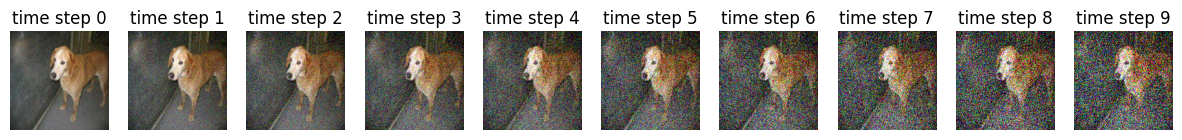

In [7]:
fig,axes = plt.subplots(1,10,figsize=(15,4))
for i in range(10) :
  image,_ = noice_makers(img,i)
  axes[i].imshow(image[0].permute(1,2,0).clip(0,1))
  axes[i].axis('off')
  axes[i].set_title(f'time step {i}')
plt.show()

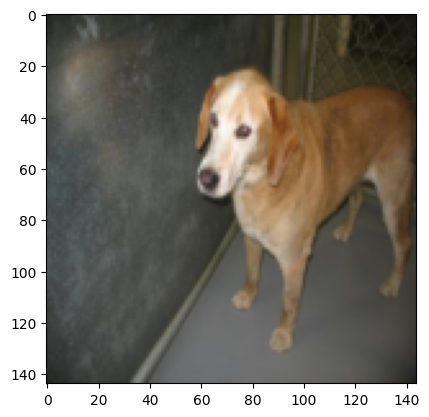

In [8]:
plt.imshow(img.permute(1,2,0).clip(0,1))
plt.show()

In [9]:
class DoubleConv (nn.Module) :
  def __init__ (self,in_channels,out_channels) :
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels,out_channels,3,padding=1),
        nn.BatchNorm2d(out_channels),
        nn.SiLU(inplace=True),
        nn.Conv2d(out_channels,out_channels,3,padding=1),
        nn.BatchNorm2d(out_channels),
        nn.SiLU(inplace=True)
    )

  def forward (self,x) :
    return self.conv(x)

In [10]:
import math

In [11]:
class TimestepsEmbedding (nn.Module) :
  def __init__ (self,time_dim = 64,d_model = 128) :
    super().__init__()
    self.time_dim= time_dim
    self.layers = nn.Sequential(
        nn.Linear(time_dim,d_model),
        nn.SiLU(),
        nn.Linear(d_model,d_model),
        nn.SiLU(),
        nn.Linear(d_model,d_model)
    )

  def timesteps (self,time,time_dim) :
    device = time.device
    halfdim = time_dim// 2
    freqs = torch.exp(-math.log(10000) * torch.arange(0,halfdim,device=device) / halfdim)
    args = time.float().unsqueeze(1) * freqs.unsqueeze(0)
    emb = torch.cat([torch.sin(args),torch.cos(args)],dim=-1)
    if time_dim % 2 == 1 :
      emb = f.pad(emb,(0,1),mode='constant',value=0)
    return emb

  def forward(self,time) :
    time = self.timesteps(time,self.time_dim)
    return self.layers(time)

In [12]:
class UpScale (nn.Module) :
  def __init__ (self,in_c, out_c) :
    super().__init__()
    self.conT = nn.ConvTranspose2d(in_c,in_c//2,2,2)
    self.conv = DoubleConv(in_c,out_c)
    self.t_emb = TimestepsEmbedding(in_c,out_c)

  def forward(self,x1,x2,t) :
    t = self.t_emb(t)
    t = t[:,:,None,None]
    x1 = self.conT(x1)
    diffy = x2.size()[2] - x1.size()[2]
    diffx = x2.size()[3] - x1.size()[3]
    x1 = f.pad(x1,[diffx//2,diffx-diffx//2,diffy//2,diffy-diffy//2])
    x = torch.cat([x2,x1],dim=1)
    x = self.conv(x)
    x+=t
    return x

In [13]:
class Downscale (nn.Module) :
  def __init__ (self,n_in,n_out) :
    super().__init__()
    self.layers = nn.Sequential(
        nn.MaxPool2d(2),
        DoubleConv(n_in,n_out))

  def forward(self,x) :
    return self.layers(x)

In [14]:
class DiffusionModel (nn.Module) :
  def __init__(self,n_channels = 3, n_out = 3) :
    super().__init__()
    self.in_conv = DoubleConv(n_channels,32)
    self.down1 = Downscale(32,64)
    self.down2 = Downscale(64,128)
    self.down3 = Downscale(128,256)
    self.up1 = UpScale(256,128)
    self.up2 = UpScale(128,64)
    self.up3 = UpScale(64,32)
    self.out_conv = nn.Conv2d(32,n_out,1)


  def forward (self,x,t) :
    x1 = self.in_conv(x)
    x2 = self.down1(x1)
    x3 = self.down2(x2)
    x4 = self.down3(x3)
    x = self.up1(x4,x3,t)
    x = self.up2(x,x2,t)
    x = self.up3(x,x1,t)
    return self.out_conv(x)


In [15]:
diffusion_model=DiffusionModel().to(device)

In [16]:
diffusion_model.train(True)

DiffusionModel(
  (in_conv): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): SiLU(inplace=True)
    )
  )
  (down1): Downscale(
    (layers): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1

In [17]:
optimizer = torch.optim.AdamW(diffusion_model.parameters(),lr=1e-3)
loss_fn = nn.MSELoss()

In [18]:
import wandb
wandb.init(
    project="DiffusionModel2",
    name="diffusion-training2"
)

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Currently logged in as: alpin (alpin-notworkd) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [19]:
dataloader = DataLoader(data,batch_size=128,shuffle=True)

In [48]:
for epoch in range(5) :
  total_loss = 0
  for image,_ in dataloader :
    t = torch.randint(0,50,(image.shape[0],)).to(device)
    image = image.to(device)
    image_noice,noice = noice_makers(image,t)
    y_pred = diffusion_model(image_noice,t)
    loss = loss_fn(y_pred,noice)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
  total_loss /= len(dataloader)
  print(f'epoch {epoch} loss {total_loss}')
  wandb.log({'loss':total_loss})

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


epoch 0 loss 0.024068328285855905
epoch 1 loss 0.024262558630838687
epoch 2 loss 0.023511901839959378
epoch 3 loss 0.02372374129006449
epoch 4 loss 0.023326054462516795


In [49]:
def p_sample_loop(model, shape, device, timesteps=50):
    x = torch.randn(shape, device=device)  # start from pure noise
    beta = torch.linspace(1e-3, 0.07, timesteps, device=device)
    alpha = 1.0 - beta
    alpha_bar = torch.cumprod(alpha, dim=0)

    imgs = []

    for t in reversed(range(timesteps)):
        with torch.no_grad():
            # model predicts noise ε_θ(x_t, t)
            eps_theta = model(x, torch.tensor([t], device=device).repeat(shape[0]))

        # coefficients
        alpha_t = alpha[t]
        alpha_bar_t = alpha_bar[t]
        beta_t = beta[t]

        # mean calculation (from DDPM paper eq. 11)
        coef = (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)
        mu = (1.0 / torch.sqrt(alpha_t)) * (x - coef * eps_theta)

        if t > 0:
            z = torch.randn_like(x)
            sigma = torch.sqrt(beta_t)
            x = mu + sigma * z
        else:
            x = mu

        imgs.append(x.detach().cpu())

    return imgs


In [76]:
gen = p_sample_loop(diffusion_model,shape=(1,3,144,144),device='cuda',timesteps=50)

In [79]:
torch.save(diffusion_model.state_dict(),'diffusion_model.pth')

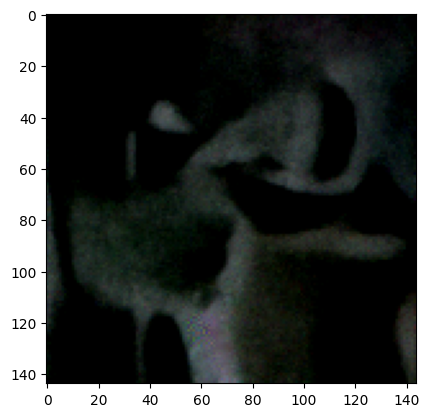

In [77]:
plt.imshow(gen[-1][0].permute(1,2,0).clip(0,1))
plt.show()

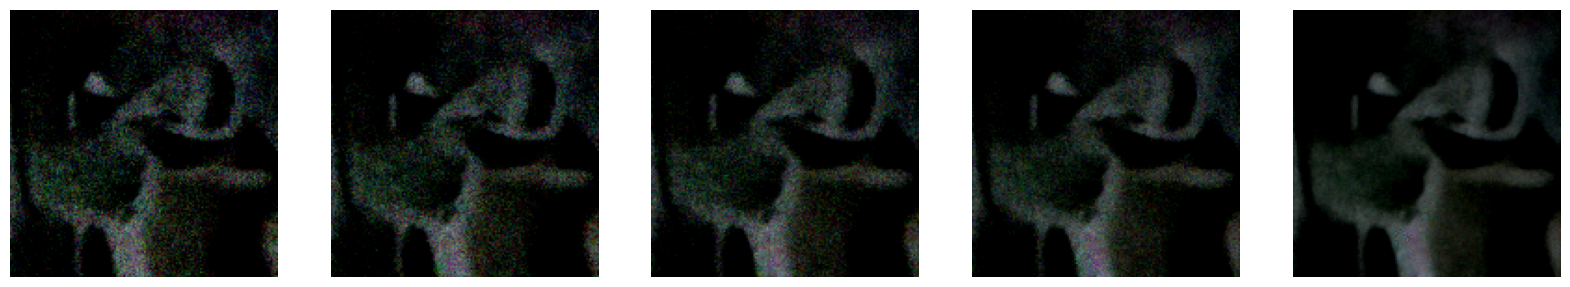

In [78]:
fig,axes = plt.subplots(1,5,figsize=(20,5))
for i in range(5) :
  axes[i].imshow(gen[i +45][0].permute(1,2,0).clip(0,1))
  axes[i].axis('off')
plt.show()